# Uncertainty Quantification for Polar Lows

In [9]:
import sys
import os

# Add the parent directory (my_project/) to Python path
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import torch 
import os
from src.dataloaders import get_transforms, create_dataloaders
from src.model_builder import *
from src.model_builder_additional import *
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from src.utils import get_device
# sort missing input scripts
from blitz.utils import variational_estimator
from blitz.modules import BayesianConv2d, BayesianLinear
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [3]:
test_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/test'
train_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/train'

# for local experiments 
# test_dir = '/Users/nicologrometto/Documents/interpretability/data/test'
# train_dir = '/Users/nicologrometto/Documents/interpretability/data/train'

device = get_device('auto')
print(device)

cuda


## Original Model 

In [4]:
train_transform, test_transform = get_transforms() 
train_loader, test_loader, n_pos_train, n_neg_train, class_to_idx_dict = create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                train_transform=train_transform,
                                                                                test_transform=test_transform)
print(class_to_idx_dict)

# Load the best model weights
model = XceptionCustom(input_channels=3)
model.load_state_dict(torch.load('../src/outputs/20.08.25_polar_lows_customex.pth'))

# for local experiments
# model.load_state_dict(torch.load('../models_local/trained_base_model.pth'))


# evaluate model 
y_pred_labels_np, y_true_np, y_pred_probs_np, misclassified_images, misclassified_true_labels, misclassified_pred_labels, misclassified_prob_vectors = evaluate_model(model, test_loader, device)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_true_np, y_pred_labels_np))
print(f"\nFound {len(misclassified_images)} misclassified images.")

Positive training samples: 254 (16%), Negative training samples: 1293 (83%)
{'neg': 0, 'pos': 1}


NameError: name 'evaluate_model' is not defined

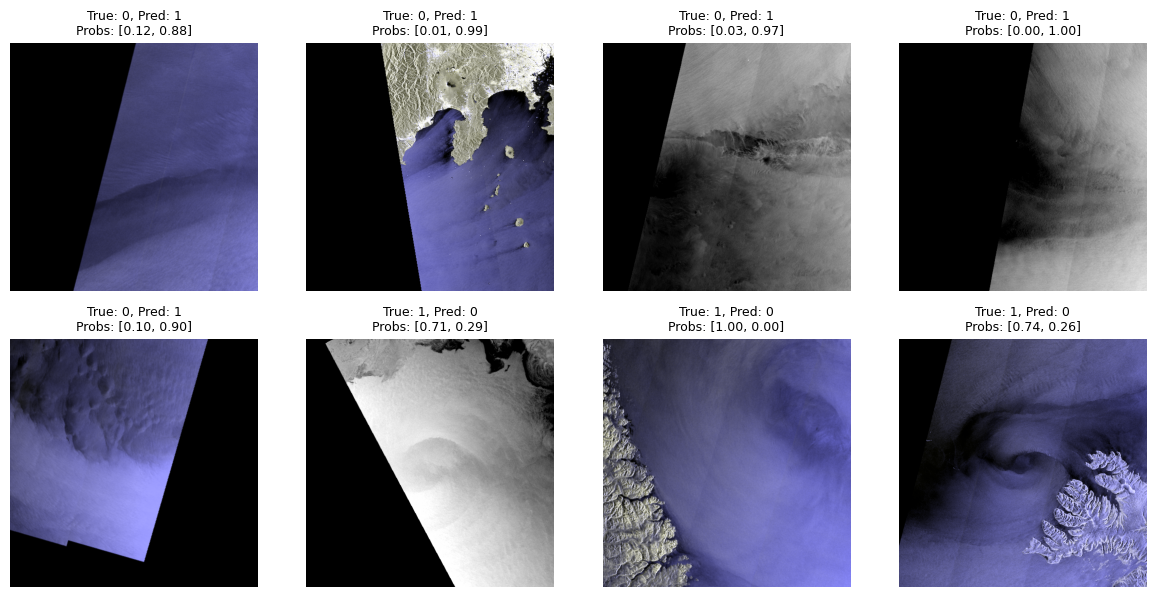

In [78]:
# --- plot misclassified images with probabilities ---
fig, axes = plt.subplots(4, 4, figsize=(12, 12)) # Create a 4x4 grid of subplots
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i in range(len(misclassified_images)):
    ax = axes[i]
    # Convert the image tensor (CHW) to NumPy array (HWC) for matplotlib
    img = misclassified_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)

    # Format the probability vector for display
    prob_vec = misclassified_prob_vectors[i].numpy()
    # Assuming two classes, e.g., [prob_neg, prob_pos]
    subtitle = f"True: {misclassified_true_labels[i]}, Pred: {misclassified_pred_labels[i]}\nProbs: [{prob_vec[0]:.2f}, {prob_vec[1]:.2f}]"
    ax.set_title(subtitle, fontsize=9) # Adjust fontsize as needed
    ax.axis('off') # Turn off the axes for each subplot

# Hide any unused subplots if fewer than 16 images are displayed
for j in range(len(misclassified_images), 16):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()

## Bayesian Base model training with BLITZ

In [7]:
def train_and_test(model, train_loader, test_loader, optimizer, criterion, device, num_epochs, train_vi_samples=1, test_vi_samples=50):
    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            loss = model.sample_elbo(
                inputs=images,
                labels=labels,
                criterion=criterion,
                sample_nbr=train_vi_samples,
                complexity_cost_weight=1/len(train_loader.dataset))
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'loss': f'{running_loss/(i+1):.4f}'})
        
        avg_train_loss = running_loss / len(train_loader)
        
        # ---- Testing ----
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Evaluate ELBO loss with more posterior samples
                loss = model.sample_elbo(
                    inputs=images,
                    labels=labels,
                    criterion=criterion,
                    sample_nbr=test_vi_samples,
                    complexity_cost_weight=len(images)/len(train_loader.dataset)
                )
                test_loss += loss.item()
                
                # Predictive mean for accuracy
                logits_samples = [model(images) for _ in range(test_vi_samples)]
                probs = torch.stack([F.softmax(logits, dim=-1) for logits in logits_samples]) # [S, B, C]
                pred_mean = probs.mean(0) # [B, C]
                pred_labels = pred_mean.argmax(dim=-1)
                correct += (pred_labels == labels).sum().item()
                total += labels.size(0)
        
        avg_test_loss = test_loss / len(test_loader)
        test_acc = correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, "
              f"Test Acc: {test_acc:.4f}")


# --- Model, Optimizer, and Loss ---
model = XceptionCustomBLITZ(input_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_and_test(model, train_loader, test_loader, optimizer, criterion, device, 100, train_vi_samples=1, test_vi_samples=50)


Epoch 1/100:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 194/194 [00:09<00:00, 19.44it/s, loss=2275.0599]


Epoch [1/100], Train Loss: 2275.0599, Test Loss: 32751.5846, Test Acc: 0.8391


Epoch 2/100:  11%|█▏        | 22/194 [00:02<00:16, 10.71it/s, loss=2098.0801]


KeyboardInterrupt: 

## Prior inspection

In [48]:
model.entry

Sequential(
  (0): BayesianConv2d(
    (weight_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
  )
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [50]:
# model.entry[0].weight_prior_dist 
for attribute in dir(model.entry[0].weight_prior_dist):
    print(attribute)

T_destination
__annotations__
__call__
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattr__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_apply
_backward_hooks
_backward_pre_hooks
_buffers
_call_impl
_compiled_call_impl
_forward_hooks
_forward_hooks_always_called
_forward_hooks_with_kwargs
_forward_pre_hooks
_forward_pre_hooks_with_kwargs
_get_backward_hooks
_get_backward_pre_hooks
_get_name
_is_full_backward_hook
_load_from_state_dict
_load_state_dict_post_hooks
_load_state_dict_pre_hooks
_maybe_warn_non_full_backward_hook
_modules
_named_members
_non_persistent_buffers_set
_parameters
_register_load_state_dict_pre_hook
_register_state_dict_hook
_replicate_for_data_parallel
_save_to_state_dict
_slow_forward
_state_dict_hooks
_state_dict_pre_hooks
_version
_wrapped_call_impl
add_modu

In [53]:
# prior appears to be a mixture of Gaussian - see below for inspection 

def prior_parameters(prior_dist):
    """Explain the mixture prior parameters"""
    print("=== Mixture Prior Interpretation ===")
    
    pi = prior_dist.pi
    sigma1 = prior_dist.sigma1  
    sigma2 = prior_dist.sigma2
    
    print(f"π (mixing weight): {pi:.6f}")
    print(f"σ₁ (first component std): {sigma1:.6f}")
    print(f"σ₂ (second component std): {sigma2:.6f}")
    
    print(f"\nThis represents a mixture of two Gaussians:")
    print(f"Component 1: N(0, {sigma1:.6f}²) with weight {pi:.6f}")
    print(f"Component 2: N(0, {sigma2:.6f}²) with weight {1-pi:.6f}")
    
    # Determine which is spike vs slab
    if sigma1 < sigma2:
        print(f"\n'Spike' (narrow): N(0, {sigma1:.6f}²) - encourages sparsity")
        print(f"'Slab' (wide): N(0, {sigma2:.6f}²) - allows larger weights")
    else:
        print(f"\n'Spike' (narrow): N(0, {sigma2:.6f}²) - encourages sparsity") 
        print(f"'Slab' (wide): N(0, {sigma1:.6f}²) - allows larger weights")

prior_parameters(model.entry[0].weight_prior_dist)

=== Mixture Prior Interpretation ===
π (mixing weight): 1.000000
σ₁ (first component std): 0.100000
σ₂ (second component std): 0.002000

This represents a mixture of two Gaussians:
Component 1: N(0, 0.100000²) with weight 1.000000
Component 2: N(0, 0.002000²) with weight 0.000000

'Spike' (narrow): N(0, 0.002000²) - encourages sparsity
'Slab' (wide): N(0, 0.100000²) - allows larger weights


## Posterior inspection

In [54]:
for attribute in dir(model.entry[0].weight_sampler):
    print(attribute)

T_destination
__annotations__
__call__
__class__
__delattr__
__dict__
__dir__
__doc__
__eq__
__format__
__ge__
__getattr__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__weakref__
_apply
_backward_hooks
_backward_pre_hooks
_buffers
_call_impl
_compiled_call_impl
_forward_hooks
_forward_hooks_always_called
_forward_hooks_with_kwargs
_forward_pre_hooks
_forward_pre_hooks_with_kwargs
_get_backward_hooks
_get_backward_pre_hooks
_get_name
_is_full_backward_hook
_load_from_state_dict
_load_state_dict_post_hooks
_load_state_dict_pre_hooks
_maybe_warn_non_full_backward_hook
_modules
_named_members
_non_persistent_buffers_set
_parameters
_register_load_state_dict_pre_hook
_register_state_dict_hook
_replicate_for_data_parallel
_save_to_state_dict
_slow_forward
_state_dict_hooks
_state_dict_pre_hooks
_version
_wrapped_call_impl
add_modu

In [61]:

print("=== Prior vs Posterior ===")
print("PRIOR (weight_prior_dist):")
prior = model.entry[0].weight_prior_dist
# Prior parameters we found earlier
print(f"  pi: {prior.pi}")
print(f"  sigma1: {prior.sigma1}")  
print(f"  sigma2: {prior.sigma2}")

print("\nPOSTERIOR (weight_sampler):")
posterior = model.entry[0].weight_sampler
print(f"  mu shape: {posterior.mu.shape}")
print(f"  mu: {posterior.mu}")

=== Prior vs Posterior ===
PRIOR (weight_prior_dist):
  pi: 1
  sigma1: 0.1
  sigma2: 0.002

POSTERIOR (weight_sampler):
  mu shape: torch.Size([8, 3, 3, 3])
  mu: Parameter containing:
tensor([[[[ 0.0305,  0.0356,  0.0061],
          [ 0.0596,  0.0218,  0.0731],
          [-0.0145,  0.0256,  0.0350]],

         [[ 0.0386,  0.0758,  0.0907],
          [ 0.0548,  0.0646, -0.0108],
          [ 0.0413,  0.0340,  0.0316]],

         [[-0.0311, -0.0402, -0.0035],
          [-0.1196, -0.0833, -0.0015],
          [ 0.0599, -0.0687,  0.0515]]],


        [[[ 0.0426,  0.0055, -0.0599],
          [-0.1826,  0.1731, -0.0641],
          [-0.0277,  0.0228, -0.0228]],

         [[-0.0637,  0.0676, -0.0612],
          [-0.0151,  0.0277,  0.0260],
          [-0.0425,  0.1017, -0.0880]],

         [[ 0.0245,  0.0441,  0.0147],
          [-0.0103, -0.1488, -0.0344],
          [ 0.0344, -0.0164,  0.0135]]],


        [[[-0.0285, -0.0555,  0.0389],
          [-0.1323, -0.0504,  0.0649],
          [-0.0155

## Evaluation of Bayesian model

In [10]:
# Example usage and training function
def train_bayesian_xception(model, train_loader, optimizer, num_epochs, device):
    """
    Training function for Bayesian Xception with ELBO loss.
    
    Args:
        model: XceptionBayesianHead model
        train_loader: DataLoader for training data
        optimizer: Optimizer (e.g., Adam)
        num_epochs: Number of training epochs
        device: Device to train on (cuda/cpu)
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            output = model(data)
            
            # Compute loss: likelihood + KL divergence
            likelihood_loss = criterion(output, target)
            kl_loss = model.sample_elbo(inputs=data,
                                       labels=target,
                                       criterion=criterion,
                                       sample_nbr=3,  # Number of samples for ELBO estimation
                                       complexity_cost_weight=1.0/len(train_loader.dataset))
            
            loss = kl_loss  # sample_elbo already includes likelihood + KL
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        print(f'Epoch {epoch} completed. Average Loss: {total_loss/len(train_loader):.4f}')


# Example instantiation
if __name__ == "__main__":
    # Create model with Bayesian head only
    model = XceptionBayesianHead(input_channels=3, 
                                filter_num=[8, 16, 32, 64, 128, 256, 512],
                                num_classes=2,
                                prior=None)  # Use default BLiTZ priors
    
    # Print model summary
    print("Model created with Bayesian classifier head only")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Bayesian parameters: {sum(p.numel() for p in model.classifier.parameters())}")
    
    # Example forward pass
    x = torch.randn(4, 3, 224, 224)
    output = model(x)
    print(f"Output shape: {output.shape}")
    
    # Example uncertainty estimation
    mean_pred, uncertainty = model.predict_with_uncertainty(x, num_samples=10)
    print(f"Mean prediction shape: {mean_pred.shape}")
    print(f"Uncertainty shape: {uncertainty.shape}")

NameError: name 'XceptionBayesianHead' is not defined